# 6 - Building a Convolutional Neural Network in TensorFlow 2.0 `keras`

So far, we've strictly dealt with "vanilla" neural networks -- now, we're going to build a full-fledged convolutional neural network using TensorFlow 2.0 `keras` before then tacking on an estimtaor of aleatoric uncertainty and transforming one of the convolutional layers of the network into a fully-conditioned probabilistic layer.

This material is adapted from the following introductory tutorial: https://www.tensorflow.org/tutorials/images/cnn

In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

print(tf.__version__)
tf.get_logger().setLevel('ERROR')

2.0.0


For this model, we'll train using the CIFAR-10 dataset from the Canadian Institute for Advanced Research. You can learn more about this dataset at the link below. For our purposes, it's enough to know that it's a ten-category image classification set with 60,000 labeled exemplars.

In [2]:
%%HTML
<iframe src="https://en.wikipedia.org/wiki/CIFAR-10" width="800" height="400"></iframe>

As you can see from the Wikipedia page, it's well-known that convolutional neural networks tend to work best at recognizing the classes in CIFAR-10. TensorFlow 2.0 ships with the `cifar10` dataset in `tf.keras.datasets`.

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

train_images, test_images = train_images / 255.0, test_images / 255.0

170500096/170498071 [==============================] - 10s 0us/step


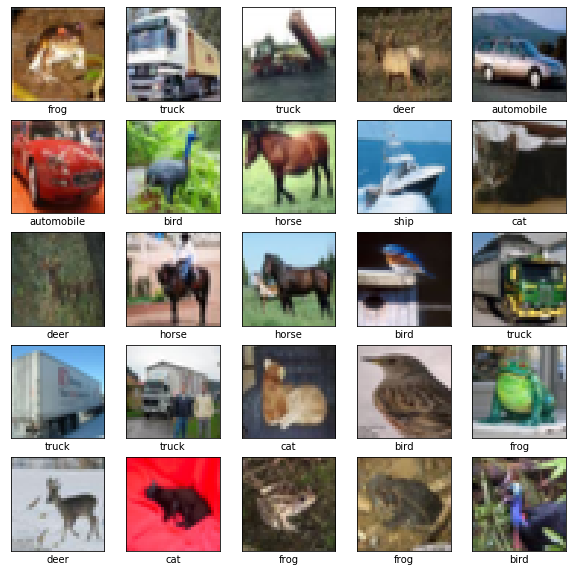

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

Let's build a convolutional neural network! As a reminder, convolutional neural networks (at least for two dimensional input) consist of _filters_ that _convolve_ around an image using a defined matrix size, typically with sevearl layers feeding into one another in order to learn progressively higher-level contextual features. See the below resources for more detailed information.

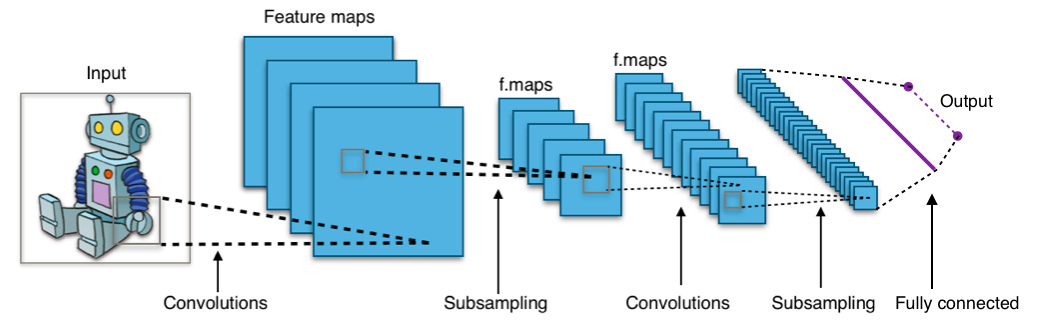

In [5]:
from IPython.display import Image
Image("Typical_cnn.png")

**Image credit: By Aphex34 - Own work, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=45679374**

In [6]:
%%HTML
<iframe src="https://en.wikipedia.org/wiki/Convolutional_neural_network" width="800" height="400"></iframe>

Although CNNs can be complex to build and train, TensorFlow 2.0 `keras` makes constructing them a snap. These hyperparameters (number of filters, kernel size, activation, etc.) are already chosen to suit our application of CIFAR-10 image classification.

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


Already we have over 56,000 parameters to learn. Three layers of convolutional filters should be plenty for this task, let's add in the classification layers to make our categorical predictions.

In [9]:
model.add(layers.Flatten())  # Strictly flattens the input without affecting size.
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))  # Softmax will squish our outputs into a distribution.

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

Over 122,000 trainable parameters -- another good case for hardward acceleration (or loading the model from prior execution).

In [11]:
checkpoint_path = 'saved_models/base_cnn_fresh.ckpt'

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
# Run this to train the model from scratch -- 10 epochs takes about 10 minutes on a CPU

# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)

# history = model.fit(train_images, train_labels, epochs=10, 
#                     validation_data=(test_images, test_labels), callbacks=[cp_callback])

# history_dict = history.history

# with open(os.path.join(os.getcwd(), 'saved_models', 'cnn_history.pkl'), 'wb') as file:
#     pickle.dump(history_dict, file)

In [13]:
# Run this to instead load pre-trained weights
model.load_weights(checkpoint_path)

with open(os.path.join(os.getcwd(), 'saved_models', 'cnn_history.pkl'), 'rb') as file:
    history_dict = pickle.load(file)

10000/1 - 2s - loss: 0.7836 - accuracy: 0.7035


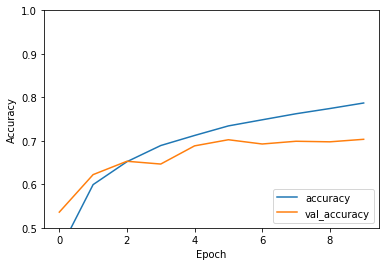

In [14]:
plt.plot(history_dict['accuracy'], label='accuracy')
plt.plot(history_dict['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [15]:
print(test_acc)

0.7035


We do show a clear tendency to overfit. Let's see if we can address that by adding some uncertainty to the model.

## Takeaways
- TensorFlow `keras` makes it easy to build complex models like convolutional neural networks that can achieve good performance on multi-class image classification problems like CIFAR-10.
- In the base instance, these networks are prone to overfitting fairly easily.